# NCI Pangu Weather Inference Notebook

# Forecast with 6 hours interval 
- This notebook shows how to use the Pangu-Weather pre-trained models for inference with the NCI-ai-ml module. 
- Two models used here are released by the Panqu-Weather team for the researchers. 
- The module belongs to the dk92 project while files belong to the wb00 project. Please, visit the NCI documentation page for more information: https://opus.nci.org.au/x/Q4RrDg

### a) Create Onnx runtime environments for interference
The following segment of code shows how to create an Onnx runtime environment for inference. At first, two models are loaded from the location: `/g/data/wb00/Pangu-Weather/model/`. Both models are trained with the Pangu-Weather but for different lead times: one for 24 hours, and the other for 6 hours. 
Afterwards, two ORT Inference sessions are created. The sessions are configured for low memory usage. Large vision transformers like the Pangu-Weather can consume a lot of memory. That is why it is important to limit memory usage for a greater number of inference steps. In this case, input data is from the NCI ERA5 repository for 1 Sep 2018 at 00 hours.  

In [1]:
import os
import numpy as np
import onnx
import onnxruntime as ort
import matplotlib
import xarray as xr
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import netCDF4 as nc


input_data_dir  = '/g/data/wb00/Pangu-Weather/data/'

model_24 = onnx.load('/g/data/wb00/Pangu-Weather/model/pangu_weather_24.onnx')
model_6  = onnx.load('/g/data/wb00/Pangu-Weather/model/pangu_weather_6.onnx')

options = ort.SessionOptions()
options.enable_cpu_mem_arena = False
options.enable_mem_pattern   = False
options.enable_mem_reuse     = False
options.intra_op_num_threads = 1

cuda_provider_options = {'arena_extend_strategy':'kSameAsRequested',}

ort_session_24 = ort.InferenceSession('/g/data/wb00/Pangu-Weather/model/pangu_weather_24.onnx', sess_options=options, providers=[('CUDAExecutionProvider', cuda_provider_options)])    
ort_session_6  = ort.InferenceSession('/g/data/wb00/Pangu-Weather/model/pangu_weather_6.onnx', sess_options=options, providers=[('CUDAExecutionProvider', cuda_provider_options)])

input = np.load(os.path.join(input_data_dir, 'input_upper_2018-09-01T00.npy')).astype(np.float32)
input_surface = np.load(os.path.join(input_data_dir, 'input_surface_2018-09-01T00.npy')).astype(np.float32)
input_24, input_surface_24 = input, input_surface

### b) 7-day (168 hours) prediction
The following segment shows how to run 7-day inference. In this case, each step makes a six-hour ahead prediction; then, it is used as the input for the next step. The for loop runs for 28 steps; thus, a 168-hour or 7-day ahead prediction is produced. If can reduce or increase the prediction lead time by changing the loop iteration number. 

In [2]:

for i in range(28):
    if (i+1) % 4 == 0:
        output, output_surface = ort_session_24.run(None, {'input':input_24, 'input_surface':input_surface_24})
        input_24, input_surface_24 = output, output_surface
    else:
        output, output_surface = ort_session_6.run(None, {'input':input, 'input_surface':input_surface})
        input, input_surface = output, output_surface

print("Done")


Done


# Visualization
The Pangu-Weather produces two prediction variables; one for the surface parameters and the other for the upper atmosphere. 
The surface level predictions are stored in the variable `output_surface`, while the upper atmosphere is in the `output`. The following graphs visualize the 7-day prediction and the ground truth. The initial input was from 1 Sep 2018 at 00 hours. Therefore, a 7-day prediction is for the date 8 Sep 2018 at 00 hours, which is shown on the right for each of the following graphs. On the other hand, the ground truth for that date, collected from the NCI ERA5 data is shown on the left. The following graphs visualise nine different variables, each separately labelled for identification. 

### 1) Mean sea level pressure

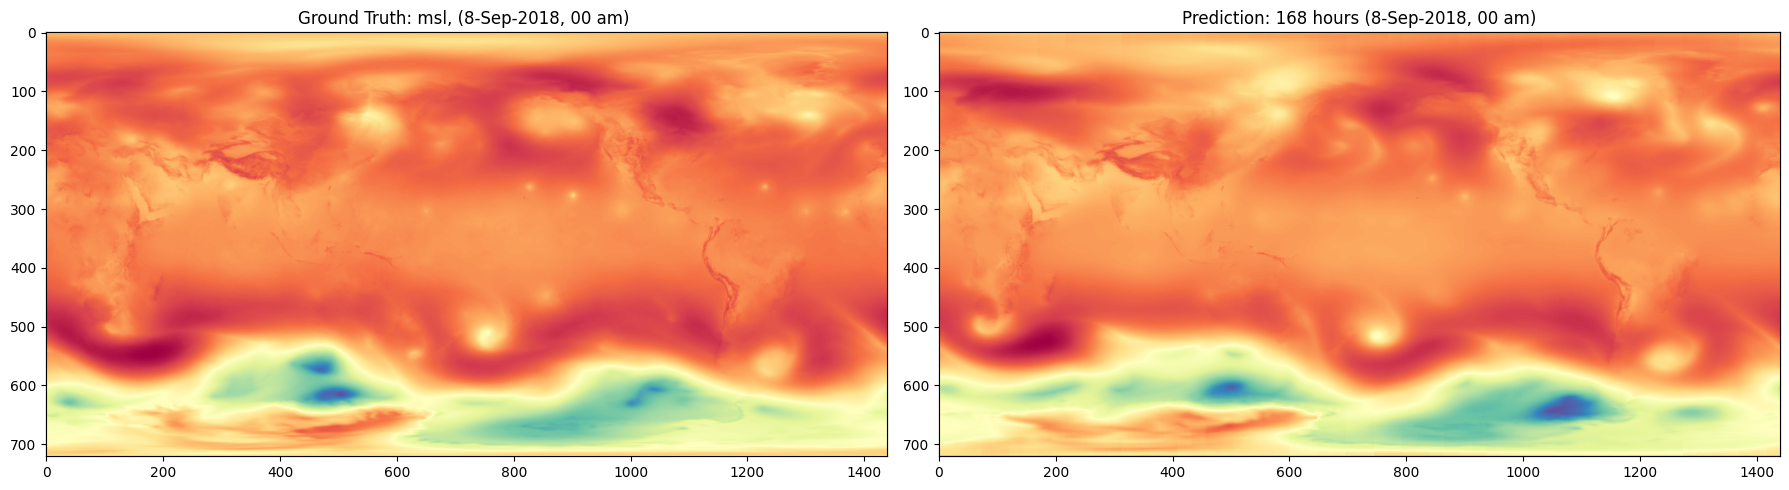

In [3]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*9, 1*5))
color_map ='Spectral_r'
color_map = 'hsv_r'
color_map = 'rainbow'
inter = 'nearest'
fig.add_subplot(1, 2, 1)
axes[0].set_title("Ground Truth: msl, (8-Sep-2018, 00 am) " )   
plt.imshow( xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/msl/2018/msl_era5_oper_sfc_20180901-20180930.nc')['msl'].sel(time='2018-09-08T00:00:00.00').roll(longitude=720).values, aspect='auto', cmap='Spectral_r' )
axes[0].set_xticks([])
axes[0].set_yticks([])   
fig.add_subplot(1, 2, 2)
axes[1].set_title("Prediction: 168 hours (8-Sep-2018, 00 am)" )
plt.imshow( output_surface[0], aspect='auto', cmap='Spectral_r' )
axes[1].set_xticks([])
axes[1].set_yticks([])     
fig.tight_layout() 
plt.subplots_adjust(hspace=0.2)  
plt.show()

### 2) U component of wind at 10m

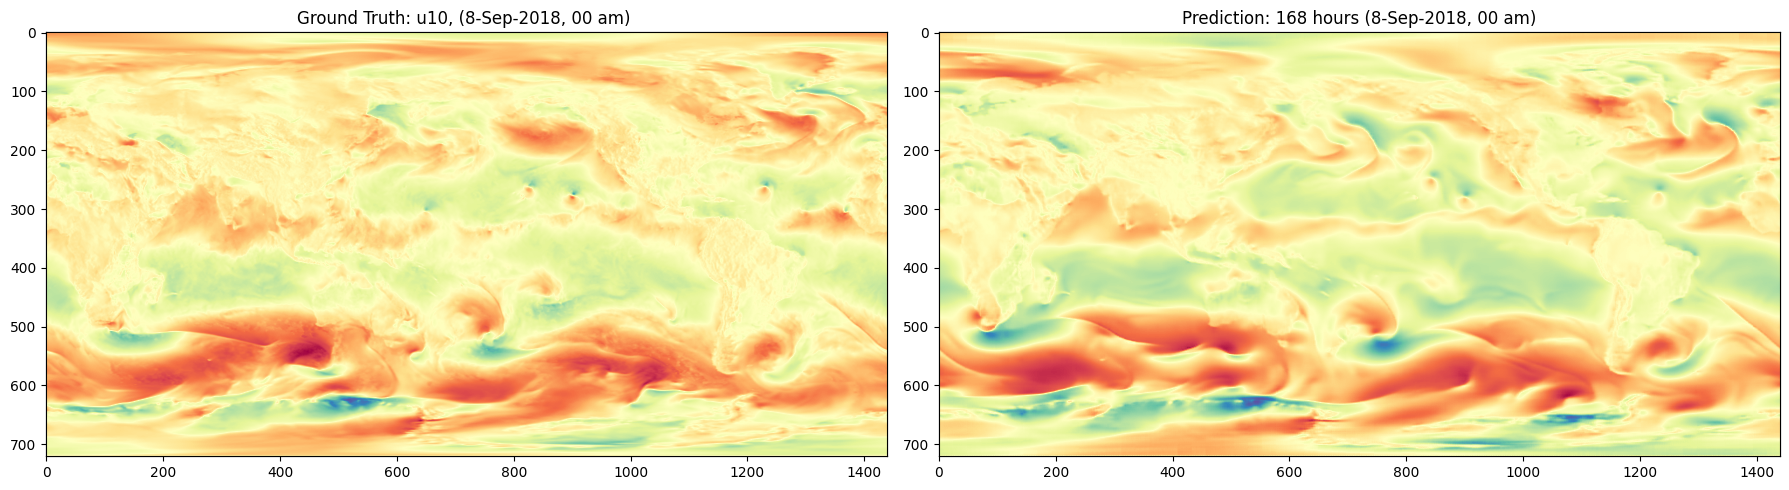

In [4]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*9, 1*5))
color_map ='Spectral_r'
color_map = 'hsv_r'
color_map = 'rainbow'
inter = 'nearest'
fig.add_subplot(1, 2, 1)
axes[0].set_title("Ground Truth: u10, (8-Sep-2018, 00 am) " )   
plt.imshow( xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/10u/2018/10u_era5_oper_sfc_20180901-20180930.nc')['u10'].sel(time='2018-09-08T00:00:00.00').roll(longitude=720).values, aspect='auto', cmap='Spectral_r' )
axes[0].set_xticks([])
axes[0].set_yticks([])   
fig.add_subplot(1, 2, 2)
axes[1].set_title("Prediction: 168 hours (8-Sep-2018, 00 am)" )
plt.imshow( output_surface[1], aspect='auto', cmap='Spectral_r' )
axes[1].set_xticks([])
axes[1].set_yticks([])     
fig.tight_layout() 
plt.subplots_adjust(hspace=0.2)  
plt.show()

### 3) V component of wind at 10m

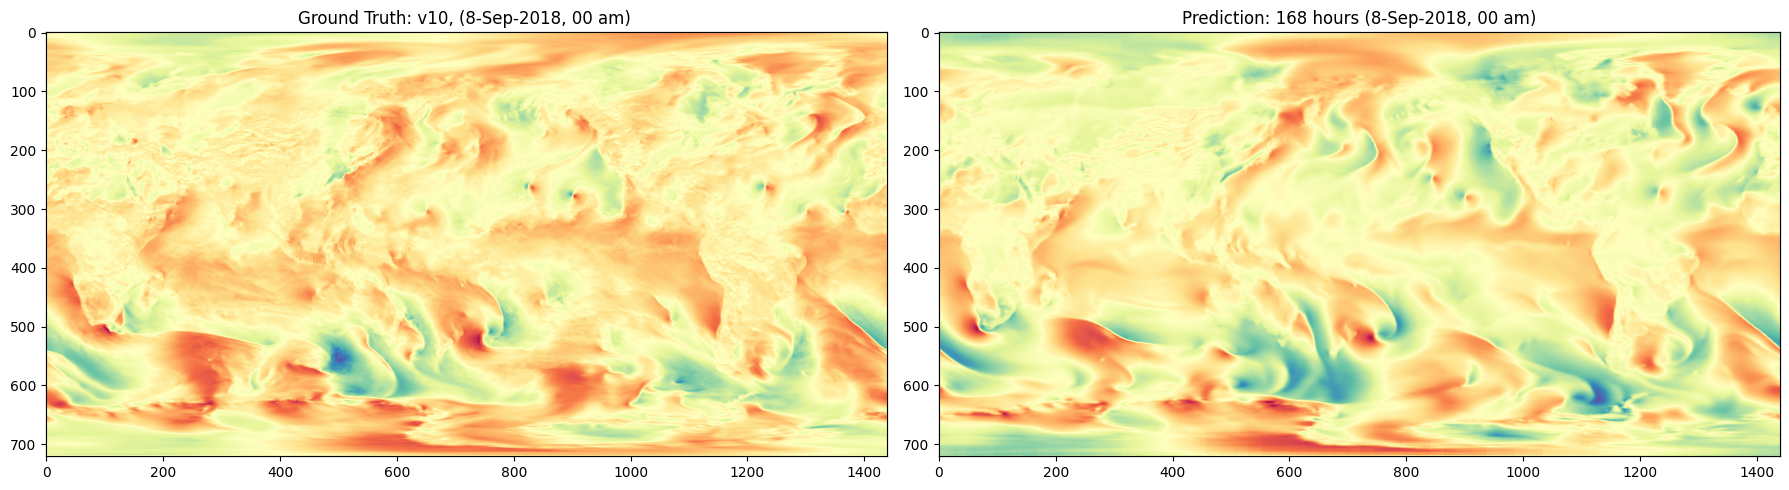

In [5]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*9, 1*5))
color_map ='Spectral_r'
color_map = 'hsv_r'
color_map = 'rainbow'
inter = 'nearest'
fig.add_subplot(1, 2, 1)
axes[0].set_title("Ground Truth: v10, (8-Sep-2018, 00 am) " )   
plt.imshow( xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/10v/2018/10v_era5_oper_sfc_20180901-20180930.nc')['v10'].sel(time='2018-09-08T00:00:00.00').roll(longitude=720).values, aspect='auto', cmap='Spectral_r' )
axes[0].set_xticks([])
axes[0].set_yticks([])   
fig.add_subplot(1, 2, 2)
axes[1].set_title("Prediction: 168 hours (8-Sep-2018, 00 am)" )
plt.imshow( output_surface[2], aspect='auto', cmap='Spectral_r' )
axes[1].set_xticks([])
axes[1].set_yticks([])     
fig.tight_layout() 
plt.subplots_adjust(hspace=0.2)  
plt.show()

### 4) Temperature at 2m

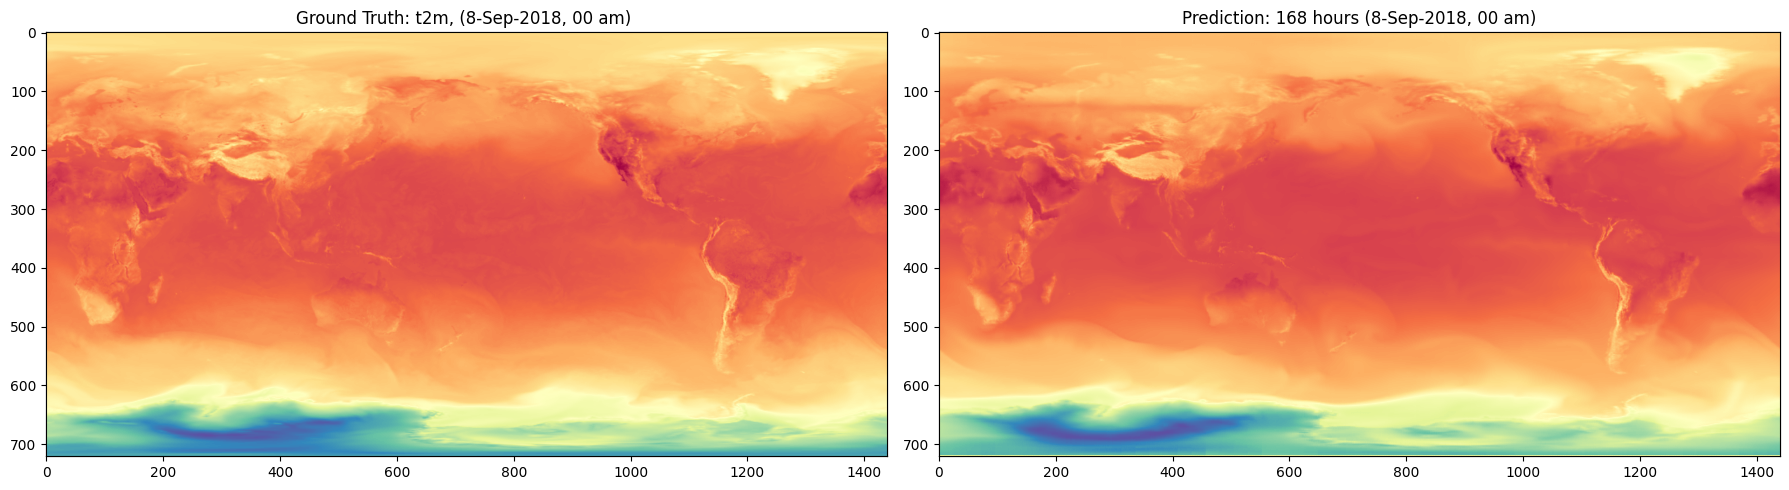

In [6]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*9, 1*5))
color_map ='Spectral_r'
color_map = 'hsv_r'
color_map = 'rainbow'
inter = 'nearest'
fig.add_subplot(1, 2, 1)
axes[0].set_title("Ground Truth: t2m, (8-Sep-2018, 00 am) " )   
plt.imshow( xr.open_dataset('/g/data/rt52/era5/single-levels/reanalysis/2t/2018/2t_era5_oper_sfc_20180901-20180930.nc')['t2m'].sel(time='2018-09-08T00:00:00.00').roll(longitude=720).values, aspect='auto', cmap='Spectral_r' )
axes[0].set_xticks([])
axes[0].set_yticks([])   
fig.add_subplot(1, 2, 2)
axes[1].set_title("Prediction: 168 hours (8-Sep-2018, 00 am)" )
plt.imshow( output_surface[3], aspect='auto', cmap='Spectral_r' )
axes[1].set_xticks([])
axes[1].set_yticks([])     
fig.tight_layout() 
plt.subplots_adjust(hspace=0.2)  
plt.show()

### 5) geopotential

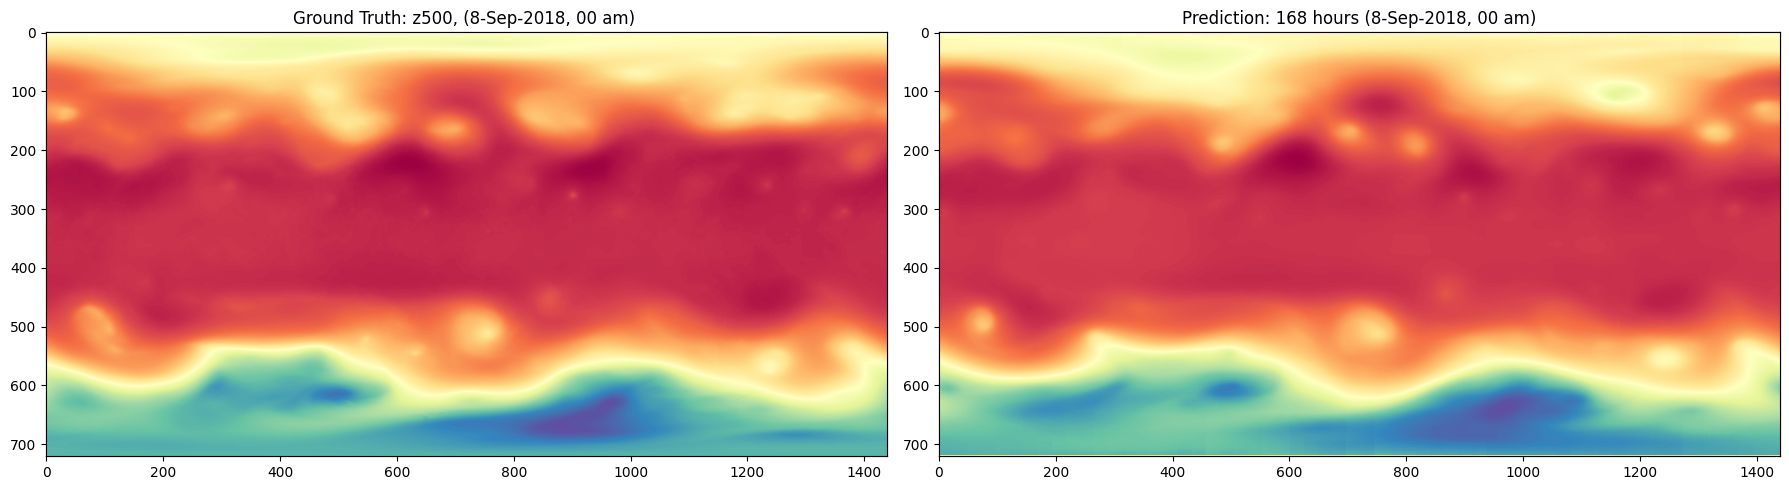

In [7]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*9, 1*5))
color_map ='Spectral_r'
color_map = 'hsv_r'
color_map = 'rainbow'
inter = 'nearest'
fig.add_subplot(1, 2, 1)
axes[0].set_title("Ground Truth: z500, (8-Sep-2018, 00 am) " )   
plt.imshow( xr.open_dataset('/g/data/rt52/era5/pressure-levels/reanalysis/z/2018/z_era5_oper_pl_20180901-20180930.nc')['z'].sel(time='2018-09-08T00:00:00.00', level=500).roll(longitude=720).values, aspect='auto', cmap='Spectral_r' )
axes[0].set_xticks([])
axes[0].set_yticks([])   
fig.add_subplot(1, 2, 2)
axes[1].set_title("Prediction: 168 hours (8-Sep-2018, 00 am)" )
plt.imshow( output[0][5], aspect='auto', cmap='Spectral_r' )
axes[1].set_xticks([])
axes[1].set_yticks([])     
fig.tight_layout() 
plt.subplots_adjust(hspace=0.2)  
plt.show()

### 6) Specific humidity

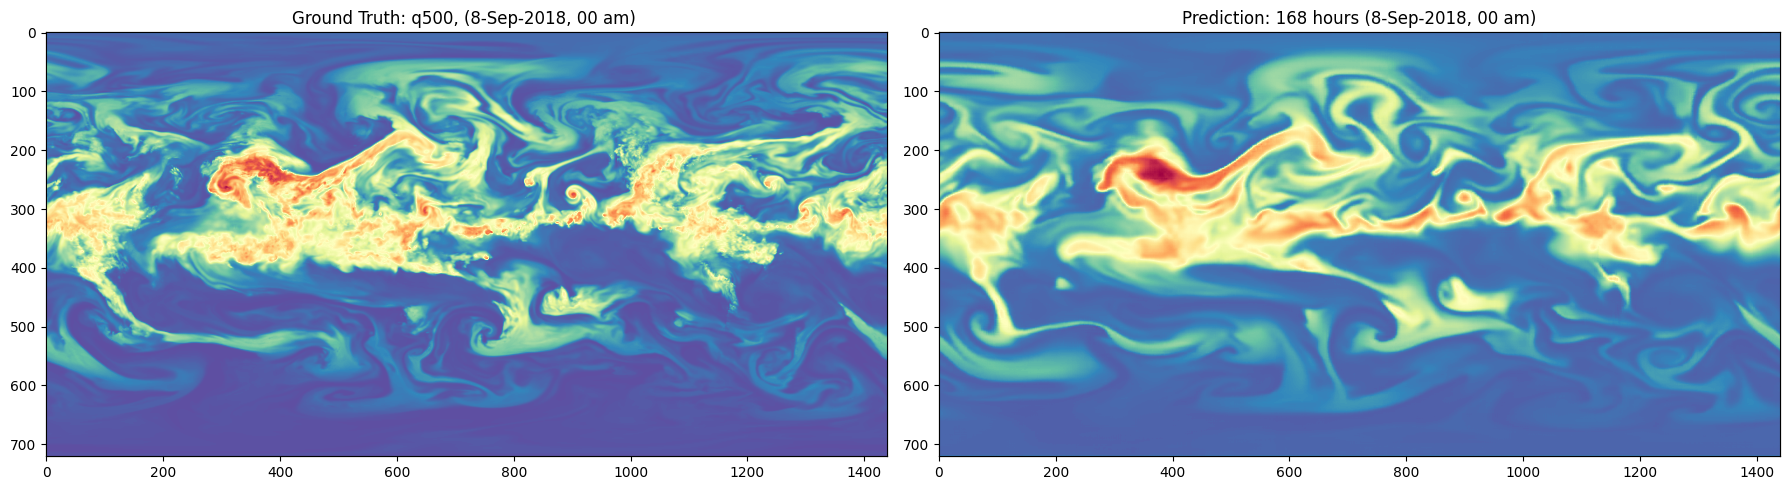

In [8]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*9, 1*5))
color_map ='Spectral_r'
color_map = 'hsv_r'
color_map = 'rainbow'
inter = 'nearest'
fig.add_subplot(1, 2, 1)
axes[0].set_title("Ground Truth: q500, (8-Sep-2018, 00 am) " )   
plt.imshow( xr.open_dataset('/g/data/rt52/era5/pressure-levels/reanalysis/q/2018/q_era5_oper_pl_20180901-20180930.nc')['q'].sel(time='2018-09-08T00:00:00.00', level=500).roll(longitude=720).values, aspect='auto', cmap='Spectral_r' )
axes[0].set_xticks([])
axes[0].set_yticks([])   
fig.add_subplot(1, 2, 2)
axes[1].set_title("Prediction: 168 hours (8-Sep-2018, 00 am)" )
plt.imshow( output[1][5], aspect='auto', cmap='Spectral_r' )
axes[1].set_xticks([])
axes[1].set_yticks([])     
fig.tight_layout() 
plt.subplots_adjust(hspace=0.2)  
plt.show()

### 7) Temperature

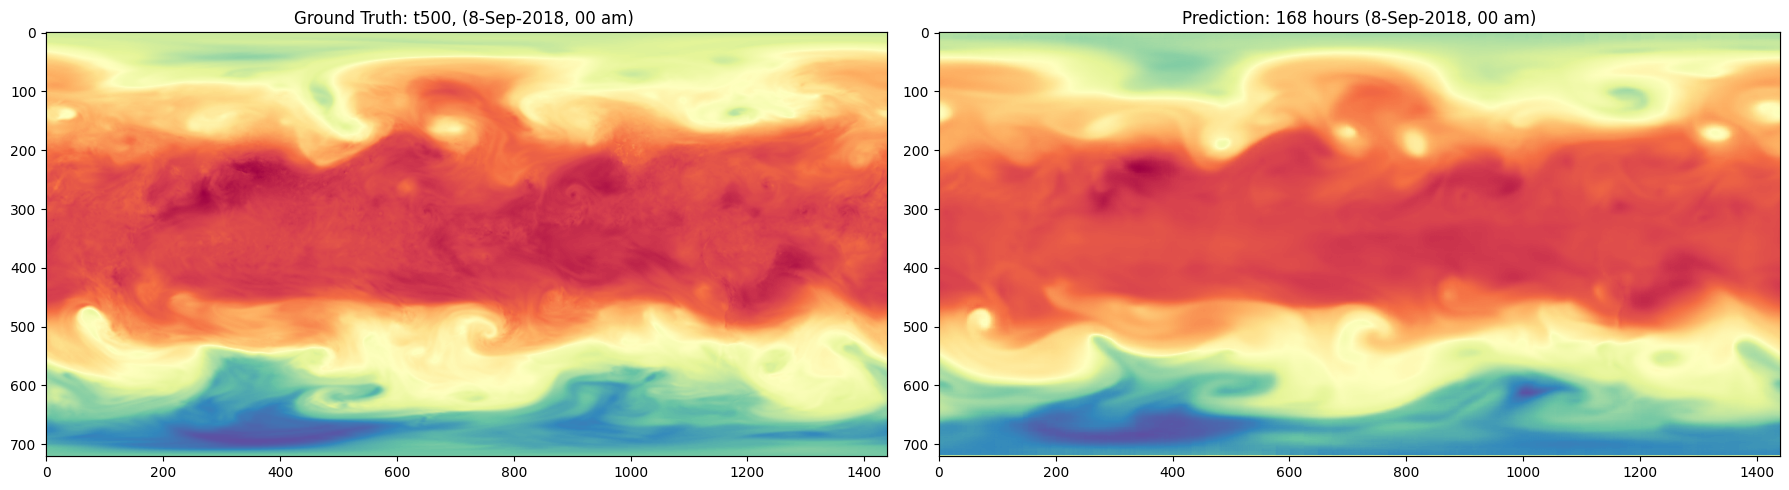

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*9, 1*5))
color_map ='Spectral_r'
color_map = 'hsv_r'
color_map = 'rainbow'
inter = 'nearest'
fig.add_subplot(1, 2, 1)
axes[0].set_title("Ground Truth: t500, (8-Sep-2018, 00 am) " )   
plt.imshow( xr.open_dataset('/g/data/rt52/era5/pressure-levels/reanalysis/t/2018/t_era5_oper_pl_20180901-20180930.nc')['t'].sel(time='2018-09-08T00:00:00.00', level=500).roll(longitude=720).values, aspect='auto', cmap='Spectral_r' )
axes[0].set_xticks([])
axes[0].set_yticks([])   
fig.add_subplot(1, 2, 2)
axes[1].set_title("Prediction: 168 hours (8-Sep-2018, 00 am)" )
plt.imshow( output[2][5], aspect='auto', cmap='Spectral_r' )
axes[1].set_xticks([])
axes[1].set_yticks([])     
fig.tight_layout() 
plt.subplots_adjust(hspace=0.2)  
plt.show()

### 8) U component of wind

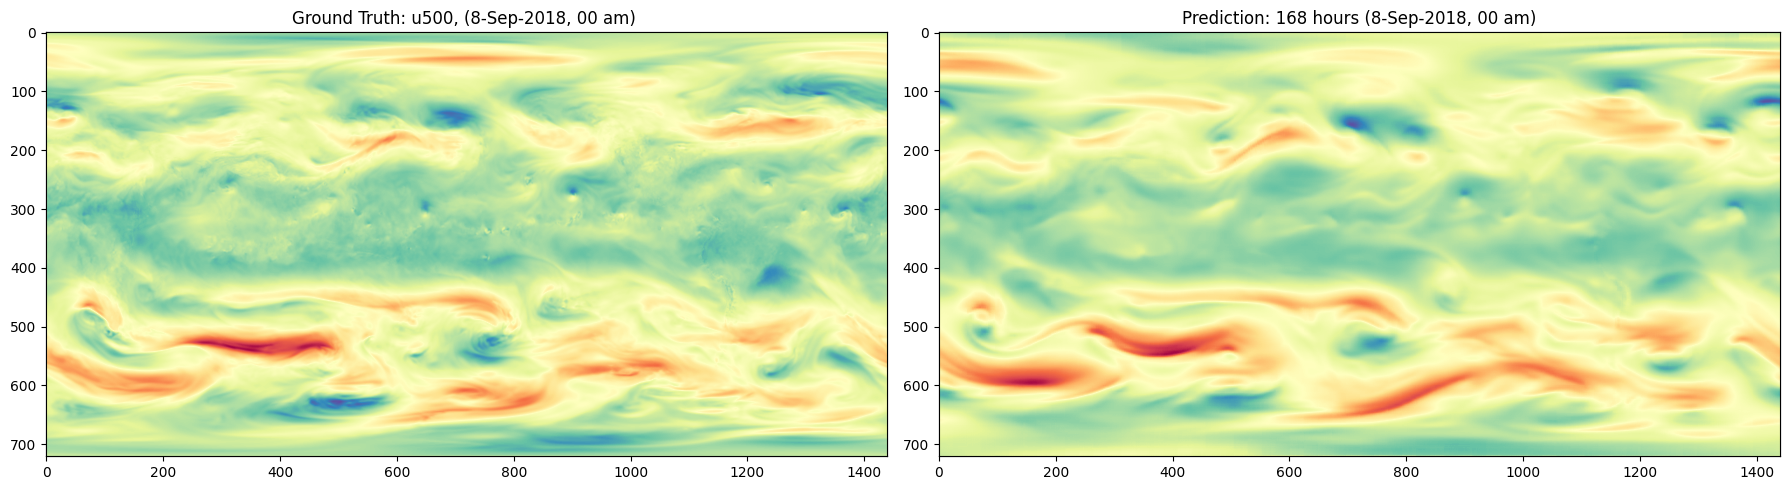

In [10]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*9, 1*5))
color_map ='Spectral_r'
color_map = 'hsv_r'
color_map = 'rainbow'
inter = 'nearest'
fig.add_subplot(1, 2, 1)
axes[0].set_title("Ground Truth: u500, (8-Sep-2018, 00 am) " )   
plt.imshow( xr.open_dataset('/g/data/rt52/era5/pressure-levels/reanalysis/u/2018/u_era5_oper_pl_20180901-20180930.nc')['u'].sel(time='2018-09-08T00:00:00.00', level=500).roll(longitude=720).values, aspect='auto', cmap='Spectral_r' )
axes[0].set_xticks([])
axes[0].set_yticks([])   
fig.add_subplot(1, 2, 2)
axes[1].set_title("Prediction: 168 hours (8-Sep-2018, 00 am)" )
plt.imshow( output[3][5], aspect='auto', cmap='Spectral_r' )
axes[1].set_xticks([])
axes[1].set_yticks([])     
fig.tight_layout() 
plt.subplots_adjust(hspace=0.2)  
plt.show()

### 9) V component of wind 

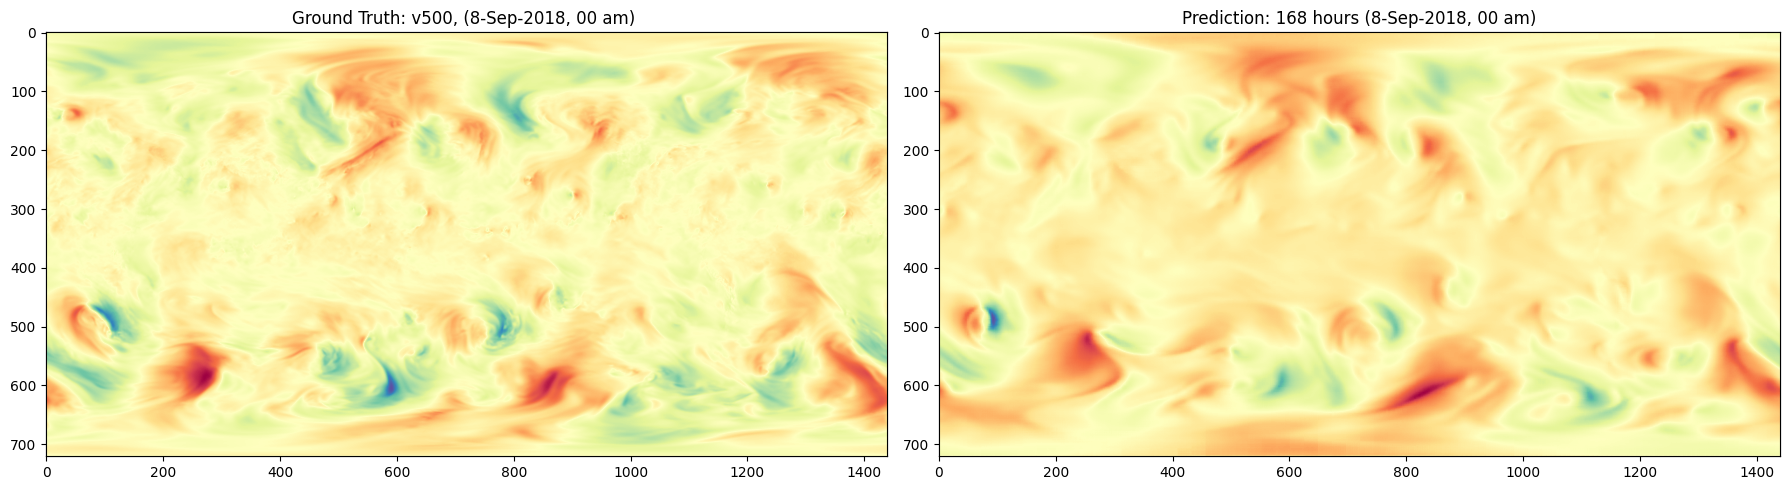

In [11]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(2*9, 1*5))
color_map ='Spectral_r'
color_map = 'hsv_r'
color_map = 'rainbow'
inter = 'nearest'
fig.add_subplot(1, 2, 1)
axes[0].set_title("Ground Truth: v500, (8-Sep-2018, 00 am) " )   
plt.imshow( xr.open_dataset('/g/data/rt52/era5/pressure-levels/reanalysis/v/2018/v_era5_oper_pl_20180901-20180930.nc')['v'].sel(time='2018-09-08T00:00:00.00', level=500).roll(longitude=720).values, aspect='auto', cmap='Spectral_r' )
axes[0].set_xticks([])
axes[0].set_yticks([])   
fig.add_subplot(1, 2, 2)
axes[1].set_title("Prediction: 168 hours (8-Sep-2018, 00 am)" )
plt.imshow( output[4][5], aspect='auto', cmap='Spectral_r' )
axes[1].set_xticks([])
axes[1].set_yticks([])     
fig.tight_layout() 
plt.subplots_adjust(hspace=0.2)  
plt.show()